# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    print('\033[91m\033[4m\033[1mFirst 5 Training examples:\033[0m')
    for i in range(0,num_examples):
        print('______________________________________________________________________________')
        print('\n\033[1m'+str(i+1)+'\033[0m. Label Description: \033[1m\033[94m'+newsgroups_train.target_names[train_labels[i]]+'\033[0m')
        print('______________________________________________________________________________')
        print(train_data[i])
    print('______________________________________________________________________________')
P1()

First 5 Training examples:
______________________________________________________________________________

1. Label Description: comp.graphics
______________________________________________________________________________
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
______________________________________________________________________________

2. Label Description: talk.religion.misc
________________________________________________

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
    print('\033[91m\033[4m\033[1m\nUse CountVectorizer to turn the raw training text into feature vectors:\n\033[0m')
    
    # Count vecorizer
    cv = CountVectorizer()
    Vecorized_train = cv.fit_transform(train_data)
    
    # Size of vocabulary
    features = cv.get_feature_names()
    print('\033[1ma.\033[0m The size of Vocabulary is: '+str(len(features)))
    
    # Non-zero features per training sample
    print('   Average # of non-zero features per sample: '+str(round(Vecorized_train.getnnz(axis=1).mean(),2)))
    
    # Non-Zero values in entire  vecorized matrix
    x,y = Vecorized_train.shape
    nz_value = Vecorized_train.nnz
    print('   % of non-zero values in the entire vecorized training data: '+str(round(100*nz_value/(x*y),2))+'%')
    
    # First and last feature string
    print('\n\033[1mb.\033[0m First feature string: '+features[0])
    print('   Last feature string: '+features[y-1])
    
    # Specify the vocablary before vectorizing
    cv_4 = CountVectorizer()
    cv_4.vocabulary = ["atheism", "graphics", "space", "religion"]
    Vectorized_train_4 = cv_4.fit_transform(train_data)
    print('\n\033[1mc.\033[0m Average # of non-zero features per sample: '
          +str(round(Vectorized_train_4.getnnz(axis=1).mean(),2)))
    
    # Use bigram and trigram char features
    cv_bigram = CountVectorizer(analyzer='char',ngram_range=(2,2))
    Vectorized_train_bigram = cv_bigram.fit_transform(train_data)
    print('\n\033[1md.\033[0m Size of bigram character vocabulary: '
          +str(len(cv_bigram.get_feature_names())))
    
    cv_trigram = CountVectorizer(analyzer='char',ngram_range=(3,3))
    Vectorized_train_trigram = cv_trigram.fit_transform(train_data)
    print('   Size of trigram character vocabulary: '+str(len(cv_trigram.get_feature_names())))
    
    # Pruning words occuring in less than 10 samples
    cv_min_df = CountVectorizer(min_df=10)
    Vectorized_train_tmin_df = cv_min_df.fit_transform(train_data)
    print('\n\033[1me.\033[0m Size of vocabulary with pruned features: '
          +str(len(cv_min_df.get_feature_names())))
    
    # Difference between feature list built from Training vs Dev data 
    cv_dev = CountVectorizer()
    Vectorized_dev_data = cv_dev.fit_transform(dev_data)
    dev_features = cv_dev.get_feature_names()
    missing_features = set(dev_features).difference(set(features))
    print('\n\033[1mf.\033[0m Size of dev vocabulary missing from Training data: '+str(len(missing_features))
          +' ('+str(round(100*len(missing_features)/len(dev_features),2))+'%)\n')
    
P2()


Use CountVectorizer to turn the raw training text into feature vectors:

a. The size of Vocabulary is: 26879
   Average # of non-zero features per sample: 96.71
   % of non-zero values in the entire vecorized training data: 0.36%

b. First feature string: 00
   Last feature string: zyxel

c. Average # of non-zero features per sample: 0.27

d. Size of bigram character vocabulary: 3291
   Size of trigram character vocabulary: 32187

e. Size of vocabulary with pruned features: 3064

f. Size of dev vocabulary missing from Training data: 4027 (24.79%)





(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [5]:
def P3():
    print('\033[91m\033[4m\033[1m\nRun the Vectorize counts through KNN, MNB and Logistic Regression models:\n\033[0m')
    # Count vecorizer
    cv = CountVectorizer()
    Vectorized_train = cv.fit_transform(train_data)
    feature = cv.get_feature_names()
    Vectorized_dev = cv.transform(dev_data)

    # Use KNN and Iterate over different Ks to find the best fit
    neighbors = {'n_neighbors': [1,5,10,50,100,150,151,152,200]}
    knn = KNeighborsClassifier()
    gridKNN = GridSearchCV(knn, neighbors)
    gridKNN.fit(Vectorized_train, train_labels)
    print('\033[1m1.\033[0m For KNN best K Value is: '+str(gridKNN.best_params_['n_neighbors']))
    
    # Train and predict KNN for K = Best K
    knn_best = KNeighborsClassifier(n_neighbors=gridKNN.best_params_['n_neighbors'])
    knn_best.fit(Vectorized_train,train_labels)
    print('   For K = '+str(gridKNN.best_params_['n_neighbors'])+', F1 Score with Dev data = '
          +str(round(100*metrics.f1_score(dev_labels,knn_best.predict(Vectorized_dev),average='macro'),2))+'%')
    
    #Use MNB and fit over the best Alpha
    alphas = {'alpha': [0.0001,0.001, 0.0046, 0.0049, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
    mnb = MultinomialNB()
    gridMNB = GridSearchCV(mnb, alphas)
    gridMNB.fit(Vectorized_train, train_labels)
    print('\n\033[1m2.\033[0m For MNB best Alpha value is: '+str(gridMNB.best_params_['alpha']))
    
    # Train and predict MNB for Alpha = Best Alpha
    mnb_best = MultinomialNB(alpha=gridMNB.best_params_['alpha'])
    mnb_best.fit(Vectorized_train, train_labels)
    print('   For Alpha = '+str(gridMNB.best_params_['alpha'])+', F1 Score with Dev data = '
          +str(round(100*metrics.f1_score(dev_labels,mnb_best.predict(Vectorized_dev),average='macro'),2))+'%')
    
    
    #Use MNB and fit over the best C
    C = {'C': [.01, 0.1, 0.15, 0.17, 0.175, 0.2, 0.3, 0.4, 0.5]}
    lr = LogisticRegression()
    gridLR = GridSearchCV(lr, C)
    gridLR.fit(Vectorized_train, train_labels)
    print('\n\033[1m3.\033[0m For LR best C value is: '+str(gridLR.best_params_['C']))
    
    # Train and predict LR model for C = Best C
    lr_best = LogisticRegression(C=gridLR.best_params_['C'])
    lr_best.fit(Vectorized_train, train_labels)
    print('   For C = '+str(gridLR.best_params_['C'])+', F1 Score with Dev data = '
          +str(round(100*metrics.f1_score(dev_labels,lr_best.predict(Vectorized_dev),average='macro'),2))+'%\n')
    
    # Get Squared sum of coefficients for each class for multiple iterations of LR model with different C values 
    print('\033[91m\033[4m\033[1m\nSquared sum of coefficients for each class for multiple iterations of LR '+
          'model with different C values:\n\033[0m')
    
    lr_weights = [.01, 0.1, 0.15, 0.17, 0.175, 0.2, 0.3, 0.4, 0.5]
    for lr_weights_ITEM in lr_weights:
        # Train and predict Logistic Regression Model for C = Best C
        lr = LogisticRegression(C = lr_weights_ITEM)
        lr.fit(Vectorized_train, train_labels)
        print('\033[91mFor C = '+str(lr_weights_ITEM)+'\033[0m')
        print('  '+str([round((lr.coef_[i]**2).sum(),2) for i in range(0,4)]))
    
P3()


Run the Vectorize counts through KNN, MNB and Logistic Regression models:

1. For KNN best K Value is: 151
   For K = 151, F1 Score with Dev data = 40.28%

2. For MNB best Alpha value is: 0.0046
   For Alpha = 0.0046, F1 Score with Dev data = 75.13%

3. For LR best C value is: 0.17
   For C = 0.17, F1 Score with Dev data = 68.95%


Squared sum of coefficients for each class for multiple iterations of LR model with different C values:

For C = 0.01
  [2.54, 2.94, 2.86, 2.25]
For C = 0.1
  [27.14, 24.66, 27.46, 23.03]
For C = 0.15
  [38.91, 34.19, 38.91, 33.24]
For C = 0.17
  [43.35, 37.71, 43.18, 37.09]
For C = 0.175
  [44.43, 38.57, 44.23, 38.03]
For C = 0.2
  [49.75, 42.75, 49.33, 42.67]
For C = 0.3
  [69.27, 57.89, 67.92, 59.77]
For C = 0.4
  [86.74, 71.17, 84.29, 75.05]
For C = 0.5
  [102.51, 83.1, 98.98, 89.0]


ANSWER:
1. The distance metric used in K-Nearest Neighbor is Euclidean distance which becomes meaningless as the dimension of the data increases. The Dimension size is of the order of thousands in this problem so it is not surprising to see such poor F1 score for KNN
2. In this specific scenario MNB outperforms Logistic Regression. My intuition behind this would be the low sample size used to train the models. Given enough sample size or some kind of dimensionality reduction method, Logistic regression can outperform MNB
3. With Increase in C, we can observe the Squared sum of all 26,879 features are incraesing for all 4 classes/ labels. This is because C is inversly proportional to the regularization parameter, which in turn governs the size of coefficients.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [6]:
import pandas as pd
def get_best_coeff(coeff, features):
    classes = ['Atheism', 'Graphics', 'Space', 'Religion']
    df_uni = pd.DataFrame(data = np.transpose(coeff), columns=classes, index=features)
    for classes_ITEM in classes:
        df_uni_tmp = df_uni.copy()
        df_uni_tmp = df_uni_tmp.sort_values(by = [classes_ITEM], ascending=False)[0:5]
        if classes.index(classes_ITEM) == 0:
            df_uni_ss1 = df_uni_tmp
        else:
            df_uni_ss1 = df_uni_ss1.append(df_uni_tmp)
    print(df_uni_ss1)
    

def P4():
    # Vecotize and run LR with Unigram fetaure
    cv = CountVectorizer()
    Vectorized_train = cv.fit_transform(train_data)
    feature = cv.get_feature_names()
    lr_best = LogisticRegression(C=0.17)
    lr_best.fit(Vectorized_train, train_labels)
    
    print('\033[91m\033[4m\033[1m\nTop 5 features with the largest weights for each label with Unigram features:\n\033[0m')
    get_best_coeff(lr_best.coef_, feature)
    
    # Vecotize and run LR with Banalyzer='char',ngram_range=(2,2)igram fetaure
    C = {'C': [0.2, 0.3, 0.32, 0.4, 0.5]}
    cv = CountVectorizer(ngram_range=(2,2))
    Vectorized_train = cv.fit_transform(train_data)
    feature = cv.get_feature_names()
    
    lr = LogisticRegression()
    gridLR = GridSearchCV(lr, C)
    gridLR.fit(Vectorized_train, train_labels)
    
    lr_best = LogisticRegression(C=gridLR.best_params_['C'])
    lr_best.fit(Vectorized_train, train_labels)
    
    print('\033[91m\033[4m\033[1m\nTop 5 features with the largest weights for each label with Bigram features:\n\033[0m')
    get_best_coeff(lr_best.coef_, feature)

P4()


Top 5 features with the largest weights for each label with Unigram features:

             Atheism  Graphics     Space  Religion
atheism     0.586168 -0.252848 -0.249885 -0.301943
religion    0.585707 -0.360907 -0.473869 -0.013792
bobby       0.585220 -0.143682 -0.204621 -0.277212
atheists    0.570050 -0.085481 -0.191737 -0.388185
islam       0.503542 -0.092044 -0.201130 -0.202565
graphics   -0.480783  1.194508 -0.785010 -0.446550
image      -0.322263  0.786370 -0.457738 -0.264161
file       -0.204794  0.767295 -0.502746 -0.351597
3d         -0.219877  0.670775 -0.388885 -0.224038
computer   -0.014714  0.650749 -0.402976 -0.277517
space      -0.779255 -0.835577  1.446314 -0.703635
orbit      -0.258558 -0.402626  0.721706 -0.320671
nasa       -0.327835 -0.307807  0.633931 -0.300348
launch     -0.258302 -0.293023  0.571183 -0.203502
spacecraft -0.211258 -0.226008  0.490884 -0.181712
christian  -0.323211 -0.234008 -0.215568  0.659406
christians -0.415359 -0.204436 -0.258110  0.625959
bl

ANSWER:
1. The unigram features with the highest weight in each Category all seems to be mutually exclusive and we see a nice diagonal trend happening as we go down the list
2. In case of bigram features, more features are common across multiple catgories. For example, 'cheers kent' and 'you are' both 'Atheism' and 'Religion'

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [115]:
from html import unescape

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    #Remove HTML characters and covert all strings into lower case characters
    s = unescape(s).lower()
    #Convert all numbers into #
    s = re.sub('\d+','#', s)
    s = re.sub('_','#', s)
    return s
    
def P5():
    print('\033[91m\033[4m\033[1m\nUse Custome Preprocessor to reduce feature size and improve F1-Score:\n\033[0m')

    # Regular Vectorization
    cv = CountVectorizer(preprocessor = empty_preprocessor)
    Vectorized_train = cv.fit_transform(train_data)
    Vectorized_dev = cv.transform(dev_data)
    feature_0 = cv.get_feature_names()
    print('\033[1m1.\033[0m Feature size with empty preprocessor: '+str(len(feature_0)))
    
    lr = LogisticRegression(C=0.17)
    lr.fit(Vectorized_train, train_labels)
    print('   F1-Score is '+str(round(100*metrics.f1_score(dev_labels,lr.predict(Vectorized_dev),average='macro'),2))+'%')
    
    # Remove Stop words, convert the documents into lower case and remove HTML entities
    cv = CountVectorizer(preprocessor = better_preprocessor,stop_words='english',min_df=1)
    Vectorized_train = cv.fit_transform(train_data)
    Vectorized_dev = cv.transform(dev_data)
    feature = cv.get_feature_names()
    print('\n\033[1m2.\033[0m Feature size with custom preprocessor*: '+str(len(feature))
         +' ('+str(round(100*(1-(len(feature)/len(feature_0))),2))+'% reduced)')
    #print(feature)
    
    lr = LogisticRegression(C=0.17)
    lr.fit(Vectorized_train, train_labels)
    print('   F1-Score is '+str(round(100*metrics.f1_score(dev_labels,lr.predict(Vectorized_dev),average='macro'),2))
          +'% (2% Increase)')
    print('\n*Notes on Preprocessor: \n(a) Removed Stop words\n(b) Removed Occurance of certain special chars like _\n(c) Removed features occuring in only one document \n(d) Hashing out nurical characters \n(e) Removed HTML characters\n(f) Normalized the documents by converting all characters to lower case\n')

    
P5()


Use Custome Preprocessor to reduce feature size and improve F1-Score:

1. Feature size with empty preprocessor: 33291
   F1-Score is 68.78%

2. Feature size with custom preprocessor*: 23705 (28.79% reduced)
   F1-Score is 70.77% (2% Increase)

*Notes on Preprocessor: 
(a) Removed Stop words
(b) Removed Occurance of certain special chars like _
(c) Removed features occuring in only one document 
(d) Hashing out nurical characters 
(e) Removed HTML characters
(f) Normalized the documents by converting all characters to lower case



(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).


Logistic Regression with L1 and L2 Regularization:

1. Features with non-Zero weights from Logistic regression with L1 regularization and C=0.17 and default Tolerance of 0.0001: 324

2. Features with non-Zero weights from Logistic regression with L2 regularization and C=0.17 and default Tolerance of 0.0001: 26879


LR Model (Accuracy and Non-Zero Feature size) with L1 Non-Zero Features and L2 prediction with Tolerance = 0.01 for different values of C:


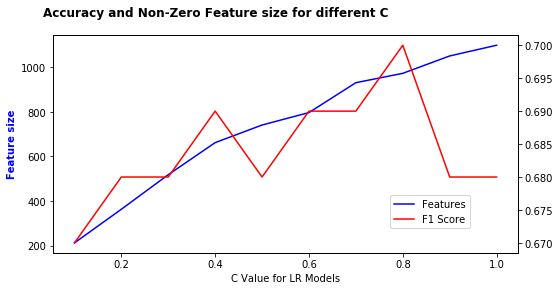

In [228]:
def nz_coeff(coeff, features):
    classes = ['Atheism', 'Graphics', 'Space', 'Religion']
    df = pd.DataFrame(data = np.transpose(coeff), columns=classes, index=features)
    df = df[(df['Atheism']!=0) | (df['Graphics']!=0) | (df['Space']!=0) | (df['Religion']!=0)]
    return df
    

def P6():
    print('\033[91m\033[4m\033[1m\nLogistic Regression with L1 and L2 Regularization:\n\033[0m')
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    cv = CountVectorizer()
    Vectorized_train = cv.fit_transform(train_data)
    feature = cv.get_feature_names()
    
    # L1 Regularization for same C value that was deemed optimal for L2 LR model in a previous Problem
    lr_L1 = LogisticRegression(penalty='l1', C=0.17)
    lr_L1.fit(Vectorized_train, train_labels)
    print('\033[1m1.\033[0m Features with non-Zero weights from Logistic regression with L1 regularization and C=0.17 and default Tolerance of 0.0001: '
          +str(len(nz_coeff(lr_L1.coef_, feature))))
    
    #L2 Regularization
    lr_L2 = LogisticRegression(C=0.17)
    lr_L2.fit(Vectorized_train, train_labels)
    print('\n\033[1m2.\033[0m Features with non-Zero weights from Logistic regression with L2 regularization and C=0.17 and default Tolerance of 0.0001: '
          +str(len(nz_coeff(lr_L2.coef_, feature)))+'\n')
    

    #reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight
    
    vocab_size = []
    f1_scores = []
    f1_scores_value = []
    
    for C_values_ITEM in C_values:
        
        # Re-Initialize standard vectorizer
        cv = CountVectorizer()
        Vectorized_train = cv.fit_transform(train_data)
        feature = cv.get_feature_names()
        
        # Train LogReg with L1 and get non-zero coeffs 
        lr_L1_tol = LogisticRegression(penalty='l1', C=C_values_ITEM, tol=0.01)
        lr_L1_tol.fit(Vectorized_train, train_labels)
        nz_coefs = nz_coeff(lr_L1_tol.coef_,feature).index.tolist()
        vocab_size.append(int(len(nz_coefs)))

        # Prune vocabulary and train new LogReg with L2
        cv.vocabulary = nz_coefs
        Vectorized_train = cv.transform(train_data)
        lr_L2_prun = LogisticRegression(penalty='l2', C=C_values_ITEM, tol=0.01)
        lr_L2_prun.fit(Vectorized_train, train_labels)
        
        # Get accuracy of dev data prediction
        Vectorized_dev = cv.transform(dev_data)
        f1_lr_L2_prun = metrics.f1_score(dev_labels, lr_L2_prun.predict(Vectorized_dev),average='macro')
        f1_scores.append(str(round(100*f1_lr_L2_prun,2))+'%')
        f1_scores_value.append(round(f1_lr_L2_prun,2))

    return vocab_size, f1_scores, f1_scores_value
    
C_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]   
vocab_F1_MAT = P6()
df = pd.DataFrame(data=np.transpose(vocab_F1_MAT),columns = ['Features','F1 Score','F1 Score Value'],index=C_values)
df['C']=df.index.tolist()

print('\033[91m\033[4m\033[1m\nLR Model (Accuracy and Non-Zero Feature size) with L1 Non-Zero Features and L2 prediction with Tolerance = 0.01 for different values of C:\033[0m')
df[['Features','F1 Score']]

#Create Visulization from DataFrame

fig, ax = plt.subplots()
rspine.set_position(('axes', 1.25))
fig.subplots_adjust(right=1.2)

df['Features'] = df['Features'].astype(int)
df['F1 Score Value'] = df['F1 Score Value'].astype(float)

df['Features'].plot(ax=ax, style='b-')
# same ax as above since it's automatically added on the right
ax1 = ax.twinx()
df['F1 Score Value'].plot(ax=ax1, style='r-', secondary_y=True)

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
fig.suptitle('Accuracy and Non-Zero Feature size for different C',fontweight='bold')
ax.set_xlabel('C Value for LR Models')
ax.set_ylabel('Feature size', color='b',fontweight='bold')
ax1.set_ylabel('F1 Score',color='r',fontweight='bold')
fig.legend([ax.get_lines()[0], ax1.right_ax.get_lines()[0]],
           ['Features','F1 Score'], bbox_to_anchor=(1.1, 0.35))
plt.show()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [386]:
def P7():

    # TF-IDF Vectorize
    cv = TfidfVectorizer()
    Vectorized_train = cv.fit_transform(train_data)
    Vectorized_dev = cv.transform(dev_data)

    # Train model and get predicted probabilities
    lg = LogisticRegression(C=100)
    lg.fit(Vectorized_train, train_labels)
    lg_dev_pred = lg.predict(Vectorized_dev)
    dev_pred_prob = lg.predict_proba(Vectorized_dev)
    
    # Create a dataframe to contain all dev documents sorted in descending order of R
    R = [ max(x) / x[dev_labels[i]] for i,x in enumerate(dev_pred_prob) ]
    
    categories = ['Atheism', 'Graphics', 'Space', 'Religion']
    labels = [categories[dev_labels_ITEMS] for dev_labels_ITEMS in dev_labels]
    labels_pred = [categories[dev_labels_ITEMS] for dev_labels_ITEMS in lg_dev_pred]
    df = pd.DataFrame({'Dev Data':dev_data, 'R':R, 'Actual Label':labels,
                       'Predicted Label':labels_pred,
                       'Atheism Prob':np.transpose(dev_pred_prob)[0],
                       'Graphics Prob':np.transpose(dev_pred_prob)[1],
                       'Space Prob':np.transpose(dev_pred_prob)[2],
                       'Religion Prob':np.transpose(dev_pred_prob)[3]
                      })
    return df.sort_values(by = ['R'], ascending=False).reset_index(drop=True)
    
TF_IDF_df = P7()
print('\nTF-IDF Vectorizer was able to predict \033[91m\033[4m\033[1m'
      +str(round(100*len(TF_IDF_df[TF_IDF_df['Actual Label']==TF_IDF_df['Predicted Label']])/len(TF_IDF_df),2))
      +'%\033[0m of the documents correctly\n')
print('\033[91m\033[4m\033[1m\nBelow are three documents with highest False positive (Highest R):\n\033[0m')
for i in range(3):
    print('______________________________________________________________________________')
    print('\n\033[1mSample '+str(i+1)+'\033[0m. Actual Label: \033[1m\033[94m'
          +TF_IDF_df['Actual Label'][i]+'\033[0m Predicted Label: \033[1m\033[91m'
          +TF_IDF_df['Predicted Label'][i]+'\033[0m and R = '+str(round(TF_IDF_df['R'][i],2)))
    print('______________________________________________________________________________')
    print('\n'+TF_IDF_df['Dev Data'][i]+'\n')
print('______________________________________________________________________________\n')
TF_IDF_df[0:3]




TF-IDF Vectorizer was able to predict 76.33% of the documents correctly


Below are three documents with highest False positive (Highest R):

______________________________________________________________________________

Sample 1. Actual Label: Religion Predicted Label: Graphics and R = 929.36
______________________________________________________________________________

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeav

,Dev Data,R,Actual Label,Predicted Label,Atheism Prob,Graphics Prob,Space Prob,Religion Prob
0,I am pleased to announce that a *revised versi...,929.358059,Religion,Graphics,0.001966,0.993720,0.003245,0.001069
1,Can anyone provide me a ftp site where I can o...,325.004068,Religion,Graphics,0.002910,0.979746,0.014329,0.003015
2,"\nThe 24 children were, of course, killed by a...",287.179193,Atheism,Religion,0.002421,0.020065,0.282269,0.695245


ANSWER: TF-IDF was able to predict 76.33% of the document labels accurately. For the documents that had a strong false positive, the following two stood out as the problem:
1. For sample 2 and 3, there are very few words and hence few features that could help predict the actual category/ class. Sample 2 seems to be a case where, even a human would not be able to predict the actual label without context of the 'Book of Mormon'. But due to the presence of words like 'ftp', 'online', 'version'...the algorithm predicted it with Computer and Graphics
2. Sample 1 has a ton of features but the number of features that oevrlap with 'Graphics' category like 'ftp', 'version', 'dba', 'ASCII', 'LATeX' easily weighs down any feature that might have predicted the category as 'Religion'

Solution:
1. For problem 1, where the number of features, is really thin. The solution could be to increase the number of features by using additional words from the dictionary which are similar in meaning of the existing words and for the given context
2. For the second problem, boosting the weight for certain context specific features and dialing down the words from other category could solve the problem

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [384]:
def P8():

    # TF-IDF Vectorize, Lowercase, Hash Numerals, Remove HTML Characters and stop words
    t_data = [unescape(x).lower().replace('\d+','#') for x in train_data]
    d_data = [unescape(x).lower().replace('\d+','#') for x in dev_data]
    cv = TfidfVectorizer(stop_words='english',min_df=1)
    Vectorized_train = cv.fit_transform(t_data)
    Vectorized_dev = cv.transform(d_data)
    
    # Train model and get predicted probabilities, Update C to 65
    lg = LogisticRegression(C=65)
    lg.fit(Vectorized_train, train_labels)
    lg_dev_pred = lg.predict(Vectorized_dev)
    dev_pred_prob = lg.predict_proba(Vectorized_dev)
    
    # Create a dataframe to contain all dev documents sorted in descending order of R
    R = [ max(x) / x[dev_labels[i]] for i,x in enumerate(dev_pred_prob) ]
    
    categories = ['Atheism', 'Graphics', 'Space', 'Religion']
    labels = [categories[dev_labels_ITEMS] for dev_labels_ITEMS in dev_labels]
    labels_pred = [categories[dev_labels_ITEMS] for dev_labels_ITEMS in lg_dev_pred]
    df = pd.DataFrame({'Dev Data':dev_data, 'R':R, 'Actual Label':labels,
                       'Predicted Label':labels_pred,
                       'Atheism Prob':np.transpose(dev_pred_prob)[0],
                       'Graphics Prob':np.transpose(dev_pred_prob)[1],
                       'Space Prob':np.transpose(dev_pred_prob)[2],
                       'Religion Prob':np.transpose(dev_pred_prob)[3]
                      })
    return df.sort_values(by = ['R'], ascending=False).reset_index(drop=True)
    
TF_IDF_df = P8()
print('\nOptimzed* TF-IDF Vectorizer was able to predict \033[91m\033[4m\033[1m'
      +str(round(100*len(TF_IDF_df[TF_IDF_df['Actual Label']==TF_IDF_df['Predicted Label']])/len(TF_IDF_df),2))
      +'%\033[0m of the documents correctly, which is 2.1% increase from Problem #7\n')


Optimzed* TF-IDF Vectorizer was able to predict 78.4% of the documents correctly, which is 2.1% increase from Problem #7

